# EAGE HPC Workshop Hackathon 2024 Starter Kit
https://github.com/yohanesnuwara/open-geoscience-repository/blob/master/how_to_open_seg_wiki.ipynb

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd

## 2D Vibroseis Line 001: [Link](https://wiki.seg.org/wiki/2D_Vibroseis_Line_001)
https://wiki.seg.org/wiki/2D_Vibroseis_Line_001

In [58]:
# !wget http://www.geofizyka.pl/2D_Land_vibro_data_2ms.tgz -P /workspace/Data/'2D_Land_vibro_data_2ms'

In [59]:
# import tarfile
# with tarfile.open('/workspace/Data/2D_Land_vibro_data_2ms/2D_Land_vibro_data_2ms.tgz', 'r:gz') as tar:
#     tar.extractall(path="/workspace/Data/2D_Land_vibro_data_2ms")

In [60]:
# !tar -xvf  '/workspace/Data/2D_Land_vibro_data_2ms/2D_Land_vibro_data_2ms.tgz' -C '/workspace/Data/2D_Land_vibro_data_2ms'

In [61]:
# !pip install segyio
import segyio

First we need to specify the `file path`.

In [62]:
filename = '/workspace/Data/2D_Land_vibro_data_2ms/Line_001.sgy'

Then, run this code to calculate the percentile of the seismic amplitudes, which later we will display as a seismic section with the amplitude color.

In [63]:
with segyio.open(filename, ignore_geometry=True) as f:
    # Get basic attributes
    n_traces = f.tracecount
    sample_rate = segyio.tools.dt(f) / 1000
    n_samples = f.samples.size
    twt = f.samples
    data = f.trace.raw[:]  # Get all data into memory (could cause on big files)
    print(n_traces, sample_rate, n_samples, data.shape)

clip_percentile = 99
vm = np.percentile(data, clip_percentile)
f'The {clip_percentile}th percentile is {vm:.0f}; the max amplitude is {data.max():.0f}'

71284 2.0 1501 (71284, 1501)


'The 99th percentile is 0; the max amplitude is 5110'

In [64]:
dt = (twt[1]-twt[0]) * 1e-3
print(dt)

0.002


The following script displays the seismic section.

In [65]:
# fig = plt.figure(figsize=(18, 8))
# ax = fig.add_subplot(1, 1, 1)
# extent = [1, n_traces, 100, twt[0]]  # define extent
# ax.imshow(data.T, cmap="gray", vmin=-vm, vmax=vm, aspect='auto', extent=extent)
# ax.set_xlabel('CDP number')
# ax.set_ylabel('TWT [ms]')
# ax.set_title('Line B11 PSTM', size=20, pad=20)

In [66]:
ntraces, nt = data.shape
nrec = 284
nsrc = int(ntraces / nrec)
print(ntraces, nt, nsrc, nrec)
data = np.reshape(data, (nsrc, nrec, nt))
print(data.shape)

71284 1501 251 284
(251, 284, 1501)


In [67]:
# Mute a couple of corrupted channels
data[:, :2, :] = 0.

In [68]:

shot = data[0, ...]
shot2 = data[100, ...]


Text(0.5, 1.0, 'Line B11 PSTM')

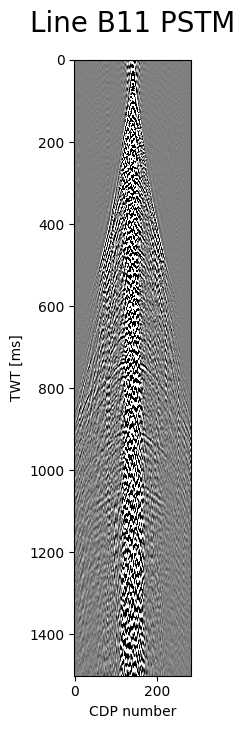

In [69]:

clip_percentile = 90
vm = np.percentile(data, clip_percentile)

fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(shot.T, cmap="gray", vmin=-vm, vmax=vm)
ax.set_xlabel('CDP number')
ax.set_ylabel('TWT [ms]')
ax.set_title('Line B11 PSTM', size=20, pad=20)

In [70]:

def plot_shot(shot, pclip=1.0, title='', colorbar=True, dt=None, dx=None, 
              figsize=None, axis=True, ax=None, cax_label='', dpi=None, **kwargs):
    """ Plot a seismic shot gather given as 2d array [offset, time] """
    if isinstance(shot, list):
        shot = np.concatenate(shot, 0)
        
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize if figsize else None);
        if dpi:
            fig.set_dpi(dpi)
        
    vlim = pclip * np.max(np.abs(shot)); 

    if dt or dx:
        nx, nt = shot.shape                                                
        kwargs['extent'] = [0, nx*dx/1000 if dx else nx, 0, nt*dt if dt else nt]
        if dx: 
            ax.set_xlabel('km');
        else: 
            ax.set_visible(False)
        if dt: 
            ax.set_ylabel('sec');
        else: 
            ax.set_visible(False)
            
    if not 'cmap' in kwargs.keys():
        kwargs['cmap'] = 'Greys'
    kwargs['vmin'] = -vlim if not 'vmin' in kwargs.keys() else kwargs['vmin']
    kwargs['vmax'] = vlim if not 'vmax' in kwargs.keys() else kwargs['vmax']
    
    im = ax.imshow(np.flip(shot, -1).T, **kwargs)
    
    if colorbar:
        divider = make_axes_locatable(ax); cax = divider.append_axes("right", size="5%", pad=0.05);
        plt.colorbar(im, cax=cax, label=cax_label);
        
    ax.set_title(title); 
    ax.axis('auto' if axis else 'off'); ax.invert_yaxis();


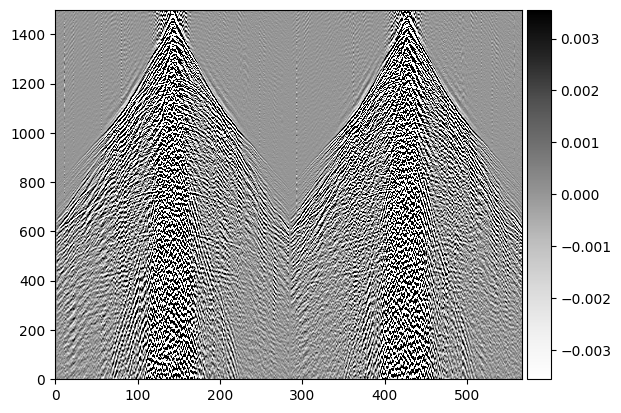

In [76]:
plot_shot([shot, shot2], pclip=0.001)

In [72]:
def plot_spectrum(shot, dt, title='', fmax=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    ps = np.sum(np.abs(np.fft.fft(shot)) ** 2, axis=-2); 
    freqs = np.fft.fftfreq(len(ps), dt); 
    idx = np.argsort(freqs)
    causal = int(len(ps) // 2); 
    freqs, ps = freqs[idx], ps[idx]; 
    freqs = freqs[-causal:]; 
    ps = ps[-causal:]; 
    freqs = freqs[freqs < (fmax if fmax else np.max(freqs))]; 
    n = len(freqs); 
    ax.plot(freqs[:n], ps[:n], label=title); 
    ax.set_xlabel('Frequency (Hz)'); 
    ax.set_ylabel('Gain'); ax.grid(True);


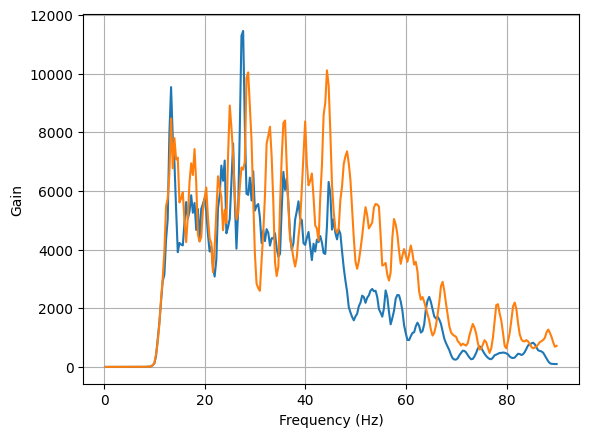

In [73]:
vfmax = 90
vfmin = 10

# shot = data[0, ...]
# shot2 = data[1, ...]

fig, ax = plt.subplots(1, 1)
plot_spectrum(shot, dt, ax=ax, fmax=vfmax)
plot_spectrum(shot2, dt, ax=ax, fmax=vfmax)

In [81]:
import os
os.chdir('/workspace/')

In [82]:
import utils.evaluate as ev

In [84]:
def print_score(val, tag, range):
    print(f'{tag}: {np.round(val, 2):.2f}\t{range}')

def evaluate(shot, shot2, dt, vfmax):
    score_amp = ev.frequency_weighted_amplitude_difference(shot, shot2, dt, fmax=vfmax)
    score_phase = ev.frequency_weighted_phase_difference(shot, shot2, dt, fmax=vfmax)
    score_combined = ev.frequency_weighted_similarity_with_phase(shot, shot2, dt, fmax=vfmax)
    score_ccor = ev.cross_correlation_similarity(shot, shot2, dt, fmax=vfmax)
    score_nrsme = ev.normalized_rmse_similarity(shot, shot2, dt, fmax=vfmax)
    
    print_score(score_amp, 'amp', '[0 <- best]')
    print_score(score_phase, 'phase', '[0 <- best]')
    print_score(score_combined, 'combined', '[0 <- best]')
    print_score(score_ccor, 'corr', '[1 <- best]')  
    print(f'nrms: {score_nrsme}\t[0 <- best]')

    # score_mi = mutual_information_similarity(shot, shot2, dt, fmax=vfmax)
    # print(score_mi)

    # score_coh = coherence_similarity(shot, shot, dt, fmax=vfmax)
    # print(score_coh)

evaluate(shot, shot2, dt, vfmax)

amp: 3.27	[0 <- best]
phase: 1.53	[0 <- best]
combined: 2.40	[0 <- best]
corr: 0.42	[1 <- best]
nrms: 0.13255080580711365	[0 <- best]


## Mobil Avo Viking Graben Line 12: [Link](https://wiki.seg.org/wiki/Mobil_AVO_viking_graben_line_12)

### Seismic

In [85]:
# !wget http://s3.amazonaws.com/open.source.geoscience/open_data/Mobil_Avo_Viking_Graben_Line_12/seismic.segy -P /workspace/Data/'Mobil'

In [86]:
filename = '/workspace/Data/Mobil/seismic.segy'

In [87]:
with segyio.open(filename, ignore_geometry=True) as f:
    # Get basic attributes
    n_traces = f.tracecount
    sample_rate = segyio.tools.dt(f) / 1000
    n_samples = f.samples.size
    twt = f.samples
    data = f.trace.raw[:]  # Get all data into memory (could cause on big files)

clip_percentile = 99
vm = np.percentile(data, clip_percentile)
f'The {clip_percentile}th percentile is {vm:.0f}; the max amplitude is {data.max():.0f}'

'The 99th percentile is 73; the max amplitude is 1317'

In [88]:
nrec = 120
nsrc = int(n_traces / nrec)
nt = n_samples
dt = 0.004
print(nsrc, nrec, nt, dt)

1001 120 1500 0.004


In [89]:
data = np.flip(np.reshape(data, (nsrc, nrec, nt)), 1)

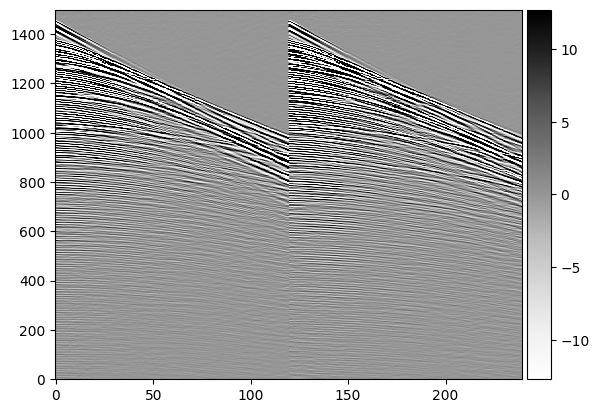

In [93]:
# fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1)
# extent = [1, nrec, twt[-1], twt[0]]  # define extent
# ax.imshow(data[2,...].T, cmap="gray", vmin=-5, vmax=5, aspect='auto', extent=extent)
# ax.set_xlabel('CDP number')
# ax.set_ylabel('TWT [ms]')
# ax.set_title('Line B11 PSTM', size=20, pad=20)

shot_m = data[0,...]
shot2_m = data[100,...]
plot_shot([shot_m, shot2_m], pclip=0.01)

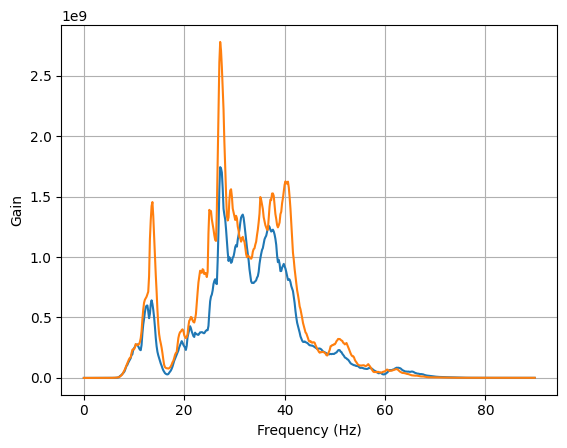

In [96]:
fig, ax = plt.subplots(1, 1)
plot_spectrum(shot_m, dt, ax=ax, fmax=vfmax)
plot_spectrum(shot2_m, dt, ax=ax, fmax=vfmax)

In [97]:
evaluate(shot_m, shot2_m, dt, vfmax)

amp: 5.96	[0 <- best]
phase: 1.54	[0 <- best]
combined: 3.75	[0 <- best]
corr: 0.66	[1 <- best]
nrms: 0.05125125125050545	[0 <- best]


## Stratton 3D [Link](https://wiki.seg.org/wiki/Stratton_3D_survey)

### Seismic (3D filtered migration)

In [78]:
!wget http://s3.amazonaws.com/open.source.geoscience/open_data/stratton/segy/processed/Stratton3D_32bit.sgy -P '/workspace/Data/Stratton/seismic'

--2024-09-10 12:38:42--  http://s3.amazonaws.com/open.source.geoscience/open_data/stratton/segy/processed/Stratton3D_32bit.sgy
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.133.152, 52.216.43.144, 52.217.33.198, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.133.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 443764680 (423M) [application/octet-stream]
Saving to: ‘/workspace/Data/Stratton/seismic/Stratton3D_32bit.sgy.1’

Stratton3D_32bit.sg 100%[===================>] 423.21M   995KB/s    in 5m 51s  

2024-09-10 12:44:34 (1.21 MB/s) - ‘/workspace/Data/Stratton/seismic/Stratton3D_32bit.sgy.1’ saved [443764680/443764680]



In [17]:
filename = '/workspace/Data/Stratton/seismic/Stratton3D_32bit.sgy'

In [18]:
# with segyio.open(filename, ignore_geometry=True) as f:
#   # print('Inline range from', min(f.ilines), 'to', max(f.ilines))
#   # print('Crossline range from', min(f.xlines), 'to', max(f.xlines)) 
#   data = f.trace.raw[:]
#   clip_percentile = 99
#   vm = np.percentile(data, clip_percentile)
#   print(f.attributes(189)[:])

# f'The {clip_percentile}th percentile is {vm:.0f}; the max amplitude is {data.max():.0f}'

In [19]:
# import re

In [0]:
def parse_trace_headers(segyfile, n_traces):
    '''
    Parse the segy file trace headers into a pandas dataframe.
    Column names are defined from segyio internal tracefield
    One row per trace
    '''
    # Get all header keys
    headers = segyio.tracefield.keys
    # Initialize dataframe with trace id as index and headers as columns
    df = pd.DataFrame(index=range(1, n_traces + 1),
                      columns=headers.keys())
    # Fill dataframe with all header values
    for k, v in headers.items():
        df[k] = segyfile.attributes(v)[:]
    return df


def parse_text_header(segyfile):
    '''
    Format segy text header into a readable, clean dict
    '''
    raw_header = segyio.tools.wrap(segyfile.text[0])
    # Cut on C*int pattern
    cut_header = re.split(r'C ', raw_header)[1::]
    # Remove end of line return
    text_header = [x.replace('\n', ' ') for x in cut_header]
    text_header[-1] = text_header[-1][:-2]
    # Format in dict
    clean_header = {}
    i = 1
    for item in text_header:
        key = "C" + str(i).rjust(2, '0')
        i += 1
        clean_header[key] = item
    return clean_header

In [0]:
with segyio.open(filename, ignore_geometry=True) as f:
    # Get basic attributes
    n_traces = f.tracecount
    sample_rate = segyio.tools.dt(f) / 1000
    n_samples = f.samples.size
    twt = f.samples
    data = f.trace.raw[:]  # Get all data into memory (could cause on big files)
    # Load headers
    bin_headers = f.bin
    # text_headers = parse_text_header(f)
    trace_headers = parse_trace_headers(f, n_traces)
f'N Traces: {n_traces}, N Samples: {n_samples}, Sample rate: {sample_rate}ms'

'N Traces: 71070, N Samples: 1501, Sample rate: 2.0ms'

In [0]:
trace_headers.columns

Index(['TRACE_SEQUENCE_LINE', 'TRACE_SEQUENCE_FILE', 'FieldRecord',
       'TraceNumber', 'EnergySourcePoint', 'CDP', 'CDP_TRACE',
       'TraceIdentificationCode', 'NSummedTraces', 'NStackedTraces', 'DataUse',
       'offset', 'ReceiverGroupElevation', 'SourceSurfaceElevation',
       'SourceDepth', 'ReceiverDatumElevation', 'SourceDatumElevation',
       'SourceWaterDepth', 'GroupWaterDepth', 'ElevationScalar',
       'SourceGroupScalar', 'SourceX', 'SourceY', 'GroupX', 'GroupY',
       'CoordinateUnits', 'WeatheringVelocity', 'SubWeatheringVelocity',
       'SourceUpholeTime', 'GroupUpholeTime', 'SourceStaticCorrection',
       'GroupStaticCorrection', 'TotalStaticApplied', 'LagTimeA', 'LagTimeB',
       'DelayRecordingTime', 'MuteTimeStart', 'MuteTimeEND',
       'TRACE_SAMPLE_COUNT', 'TRACE_SAMPLE_INTERVAL', 'GainType',
       'InstrumentGainConstant', 'InstrumentInitialGain', 'Correlated',
       'SweepFrequencyStart', 'SweepFrequencyEnd', 'SweepLength', 'SweepType',
       'Swee

In [0]:
trace_headers['CDP_X']

1        0
2        0
3        0
4        0
5        0
        ..
71066    0
71067    0
71068    0
71069    0
71070    0
Name: CDP_X, Length: 71070, dtype: int32